In [ ]:
!pip install d2l==0.16

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

简单起见，考虑下面这个回归问题：给定的成对的“输入－输出”数据集  {(x1,y1),…,(xn,yn)} ，如何学习  f  来预测任意新输入  x  的输出  y^=f(x) ？

根据下面的非线性函数生成一个人工数据集，其中加入的噪声项为  ϵ ：

(10.2.1)
yi=2sin(xi)+x0.8i+ϵ,
 
其中  ϵ  服从均值为  0  和标准差为  0.5  的正态分布。我们生成了  50  个训练样本和  50  个测试样本。为了更好地可视化之后的注意力模式，输入的训练样本将进行排序。

In [3]:
n_train=50  #训练样本数
x_train,_=torch.sort(torch.rand(n_train)*5) #训练样本的输入

def f(x):
  return 2*torch.sin(x)+x**0.8

y_train=f(x_train)+torch.normal(0.0,0.5,(n_train,)) #训练样本的输出
x_test=torch.arange(0,5,0.1)  #测试样本
y_truth=f(x_test)  #测试样本的真实输出
n_test=len(x_test)
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示）、不带噪声项的真实数据生成函数  f （标记为“Truth”）和学习得到的预测函数（标记为“Pred”）。

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

先使用可能是这个世界上“最愚蠢”的估计器来解决回归问题：基于平均汇聚来计算所有训练样本输出值的平均值：

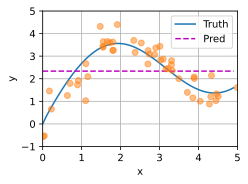

In [5]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

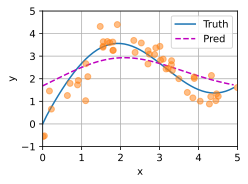

In [6]:
# `X_repeat` 的形状: (`n_test`, `n_train`),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# `x_train` 包含着键。`attention_weights` 的形状：(`n_test`, `n_train`),
# 每一行都包含着要在给定的每个查询的值（`y_train`）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# `y_hat` 的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在，让我们来观察注意力的权重。这里测试数据的输入相当于查询，而训练数据的输入相当于键。因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近，注意力汇聚的注意力权重就越高。

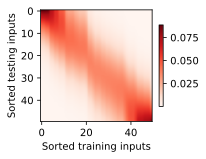

In [7]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

为了更有效地计算小批量数据的注意力，我们可以利用深度学习开发框架中提供的批量矩阵乘法。

假设第一个小批量数据包含  n  个矩阵  X1,…,Xn ，形状为  a×b ，第二个小批量包含  n  个矩阵  Y1,…,Yn ，形状为  b×c 。它们的批量矩阵乘法得到  n  个矩阵  X1Y1,…,XnYn ，形状为  a×c 。因此，假定两个张量的形状分别是  (n,a,b)  和  (n,b,c)  ，它们的批量矩阵乘法输出的形状为  (n,a,c) 。

In [8]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值。

In [9]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

基于 (10.2.7) 中的带参数的注意力汇聚，使用小批量矩阵乘法，定义 Nadaraya-Watson 核回归的带参数版本为：

In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # `queries` 和 `attention_weights` 的形状为 (查询个数, “键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # `values` 的形状为 (查询个数, “键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

接下来，将训练数据集转换为键和值用于训练注意力模型。在带参数的注意力汇聚模型中，任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算，从而得到其对应的预测输出。

In [11]:
# `X_tile` 的形状: (`n_train`, `n_train`), 每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# `Y_tile` 的形状: (`n_train`, `n_train`), 每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# `keys` 的形状: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# `values` 的形状: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

训练带参数的注意力汇聚模型时使用平方损失函数和随机梯度下降。

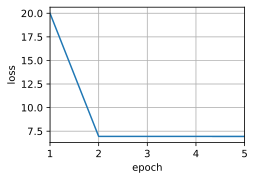

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    # 注意：L2 Loss = 1/2 * MSE Loss。
    # PyTorch 的 MSE Loss 与 MXNet 的 L2Loss 差一个 2 的因子，因此被除2。
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

训练完带参数的注意力汇聚模型后，我们发现，在尝试拟合带噪声的训练数据时，预测结果绘制的线不如之前非参数模型的线平滑。

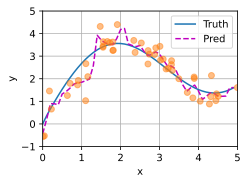

In [13]:
# `keys` 的形状: (`n_test`, `n_train`), 每一行包含着相同的训练输入（例如：相同的键）
keys = x_train.repeat((n_test, 1))
# `value` 的形状: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

与非参数的注意力汇聚模型相比，带参数的模型加入可学习的参数后，在输出结果的绘制图上，曲线在注意力权重较大的区域变得更不平滑。

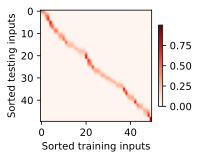

In [14]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')